In [692]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
import plotly.express as px

mpl.rc('font', family='Malgun Gothic')

In [693]:
df1 = pd.read_csv('11_Data.csv')
df1.head()

,Unnamed: 0,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,...,Flux480s,Flux840s,input_Energy,Temp_implantation,Furance_Temp,RTA_Temp,Target,Error_message,target_binom,Chamber_Route
0,0,1,Oxidation,dry,1138.979159,O2,32.80,0.200,62.0,699.443,...,3.002593e+17,6.000007e+17,31574.410,102.847,885.0,154,96,none,0.0,route_11133
1,1,1,Oxidation,dry,1218.184551,O2,31.86,0.194,137.0,696.792,...,3.017903e+17,6.000012e+17,31580.213,104.323,919.0,154,102,none,0.0,route_11222
2,2,1,Oxidation,dry,1062.467808,O2,39.51,0.217,128.0,705.471,...,2.994231e+17,6.000002e+17,32162.414,100.605,916.0,155,95,none,0.0,route_11311
3,3,1,Oxidation,dry,1114.704773,O2,32.88,0.201,90.0,710.772,...,2.991354e+17,6.000003e+17,32874.925,101.739,911.0,156,117,none,0.0,route_12111
4,4,1,Oxidation,dry,989.411946,O2,38.11,0.204,98.0,716.975,...,3.005576e+17,6.000013e+17,30985.928,106.422,872.0,155,143,none,0.0,route_12222


# Ensemble Model

- 기존에 존재하는 여러가지 알고리즘을 결합 또는 조합하여 새로운 형태의 강력한 알고리즘을 생성

1) Voting Model : 서로 다른 알고리즘을 결합하여 가장 좋은 성능의 알고리즘을 찾아 사용하는 기법

    - Train Data -> 1) DT / 2) Logistic / 3) SVM ... -> Best Model

2) Bagging Model : 학습데이터에서 서로 다른 복원추출(Sub-Sampling)된 데이터를 하나의 알고리즘이 여러번 학습해나온 결과를 결합하여 하나의 강력한 모델을 구성하는 방법

    - Sub Sampling : 1000개 Data 
        1) 700개 무작위 추출 - DT학습
        2) 700개 무작위 추출 - DT학습
        3) 700개 무작위 추출 - DT학습
        ... -> 위에서 학습된 Model을 결합 

3) **Boosting Model** : 앞서 Bagging기법과 같이 복원추출된 데이터를 하나의 모델이 학습
학습을 수행할 때 마다 이전의 학습결과를 반영하여 다음 복원추출 단계에 반영해 학습
    - DT Model : 비모수데이터 잘 작동 / 과적합 


In [694]:
# 1. X/Y를 선언한다
Y = df1['target_binom']     # wafer 폐기 여부를 분류하는 알고리즘을 구성
X = df1[['type', 'UV_type', 'thickness', 'resist_target', 'Line_CD', 'Etching_rate']]

In [695]:
# 2. 지도학습에 필요한 라이브러리를 호출
from sklearn.model_selection import train_test_split
from sklearn.compose        import make_column_transformer
from imblearn.pipeline      import pipeline
from imblearn.pipeline      import make_pipeline
from sklearn.impute         import SimpleImputer, KNNImputer
from sklearn.preprocessing  import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier # Bagging Model 
from sklearn.model_selection import GridSearchCV    # 교차검증
from sklearn.metrics   import classification_report     # 평가
import pickle


In [696]:
# 3. 학습/검증 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

In [697]:
# 4. 파이프라인을 구성한다.
numeric_pipe = make_pipeline(KNNImputer(), MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
numeric_list = X.describe().columns.tolist()
category_list = X.describe(include='object').columns.tolist()
preprocessing_pipe = make_column_transformer((numeric_pipe, numeric_list)
                                            , (category_pipe, category_list))
model_pipe = make_pipeline(preprocessing_pipe, ADASYN(), RandomForestClassifier())

In [698]:
# 5. 교차검증 및 하이퍼 파라미터 튜닝
hyperparameter_list = {'randomforestclassifier__max_depth':range(5,11)
                        , 'randomforestclassifier__min_samples_leaf':range(5,11)
                        , 'randomforestclassifier__min_samples_split':range(5,11)}
grid_model = GridSearchCV(model_pipe, param_grid=hyperparameter_list
                            , cv=5, n_jobs=-1, scoring='f1')
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['thickness',
                                                                          'resist_target',
                                                                          'Line_CD',
                                                                          'Etching_rate']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['type',
                                                                          'UV_type'])])),
                                       ('adasyn', ADASYN()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 11),
                         'randomforestclassifier__min_samples_leaf': range(5, 11),
                         'randomforestclassifier__min_samples_split': range(5, 11)},
             scoring='f1')

In [699]:
# 6. 평가
best_model = grid_model.best_estimator_

Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

In [700]:
print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94       482
         1.0       0.42      0.86      0.56        44

    accuracy                           0.89       526
   macro avg       0.70      0.88      0.75       526
weighted avg       0.94      0.89      0.90       526



In [701]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89       206
         1.0       0.24      0.50      0.32        20

    accuracy                           0.81       226
   macro avg       0.59      0.67      0.61       226
weighted avg       0.88      0.81      0.84       226



- 변수 중요도 (Feature Importance)
    - 분류를 수행함에 있어, 각 Feature가 얼마나 분류에 기여를 하였는가
    - Data를 나눌때 기여도가 높은 Column 확인
    - 회귀분석의 회귀계수의 개념과는 다르다. 
    - 변수중요도가 높다 해서 Y값이 직접적으로 변하지 않는다.

- 회귀분석 Y = 100 X1 + 200 X2 + 3 X3 + 30

In [702]:
encoder_list = best_model.named_steps['columntransformer'].transformers_[1][1].named_steps['onehotencoder'].get_feature_names().tolist()

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [703]:
df_importance = pd.DataFrame()
df_importance['Feature'] = pd.Series(numeric_list + encoder_list)
df_importance['Importance']= best_model['randomforestclassifier'].feature_importances_


In [704]:
df_importance

,Feature,Importance
0,thickness,0.212675
1,resist_target,0.191311
2,Line_CD,0.109147
3,Etching_rate,0.370594
4,x0_dry,0.027678
5,x0_wet,0.021933
6,x1_G,0.011720
7,x1_H,0.025356
8,x1_I,0.029586


<AxesSubplot:xlabel='Feature', ylabel='Importance'>

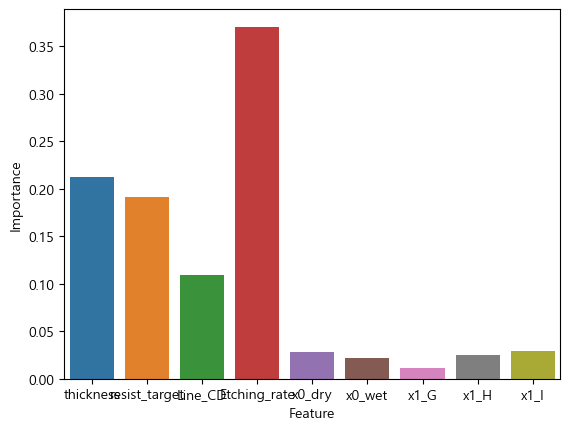

In [705]:
sns.barplot(data=df_importance, x='Feature', y='Importance')

In [706]:
# 7. 모델 파일형태로 저장
pickle.dump(best_model, open('model_best.sav','wb'))

# Boosting
- 데이터에서 복원추출된 표본을 알고리즘이 학습하여 구성될 때 마다 오차를 줄여나가는 방향으로 학습해, 점진적으로 향상된 모델을 도출하는 방식
- 전통적인 기계학습 모델 중에 가장 성능이 좋고 가장 많이 사용
- Boosting Model 종류 : 
    - Ada Boosting (Adaptive Boosting) : 이전에 학습의 결과에 잘 반영이 되지 않은 데이터에 대해 Weight(가중치)를 부여하여 복원추출을 수행
        - 앞서 분류가 제대로 수행되지 못한 데이터에 대해 가중을 주어 성능을 향상
        - 데이터 이상치가 존재하는 경우, 이상치에 대해 가중을 주며 학습을 수행하므로 지속적 학습에 대해 성능이 개선되지 않을 가능성이 존재
        - 앞서 가중치가 너무 높게 부여가 되면, 가중치가낮게 부여된 데이터들에 대해 오분류 될 가능성 존재
    
    - Gradient Boosting : Ada Boosting모델에서 이상치가 많거나 너무 높게 weight에 대해 주변 값들이 오분류 될 가능성이 매우 높음
        - 오분류 된 값에 가중치를 부여할 때마다, 가중치의 오차의 제곱이 최소가 되는 방향으로 (최소제곱법) 가중치를 함수 형태로 갱신하여 학습
        - 가중치(함수)를 최적화하여 (최소제곱법 + 경사하강법, Minimization) 부여 
        - Ada boosting 모델 보다 더욱 민감한 모델을 구성
        - 시간 오래 소요 / (학습율을 잘 조절하지 못하면) 과적합

    - XGBoosting : Gradient Boosting Model에 과적합 현상을 방지하기 위해, 규제항(Regularization) 추가하여 학습을 수행
        - Tree 구조가 복잡해지지 않도록 규제항(다양하게 선택 적용)을 추가
        - 속도가 더 느려짐
    - Light Boosting : boosting 계열의 모델들이 속도가 매우 저조한 현상을 개선하기 위해, 복원추출되는 데이터의 양을 조절해 학습을 수행
        - 시간과 자원의 소요를 효과적으로 줄여주는 학습기법
        - XGBoosting 기반으로 구성된 알고리즘 이므로, 과적합 현상도 적절하게 방지
    - Catboosting (Categorical Boosting) : 범주형 데이터로 부터 얻은 OneHotEncoding된 더미 변수들에 대해 Boosting기법을 적용하여 학습하는 기법
        - Dummy 화 된 변수를 그룹으로 분할하여 학습 및 처리
        

In [707]:
# !pip install --user xgboost
# !pip install --user lightgbm
# !pip install --user catboost

In [708]:
from lightgbm import LGBMClassifier

In [709]:
help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 |  LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable, NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None, n_jobs: int = -1, silent: Union[bool, str] = 'warn', importance_type: str = 'split', **kwargs)
 |  
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      sklearn.base.ClassifierMixin
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Met

In [710]:
model_pipe = make_pipeline(preprocessing_pipe, ADASYN(), LGBMClassifier())

In [711]:
hyper_parameter = {'lgbmclassifier__max_depth':range(5,11)
                    , 'lgbmclassifier__n_estimators':[50, 100, 200]
                    , 'lgbmclassifier__learning_rate':[0.1, 0.01, 0.001]}

grid_model = GridSearchCV(model_pipe, param_grid=hyper_parameter
                            , cv=5, n_jobs=-1, scoring='f1')
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['thickness',
                                                                          'resist_target',
                                                                          'Line_CD',
                                                                          'Etching_rate']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['type',
                                                                          'UV_type'])])),
                                       ('adasyn', ADASYN()),
                                       ('lgbmclassifier', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__learning_rate': [0.1, 0.01, 0.001],
                         'lgbmclassifier__max_depth': range(5, 11),
                         'lgbmclassifier__n_estimators': [50, 100, 200]},
             scoring='f1')

In [712]:
best_model = grid_model.best_estimator_
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

In [713]:
print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94       482
         1.0       0.42      0.89      0.57        44

    accuracy                           0.89       526
   macro avg       0.70      0.89      0.75       526
weighted avg       0.94      0.89      0.90       526



In [714]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.88       206
         1.0       0.23      0.55      0.33        20

    accuracy                           0.80       226
   macro avg       0.59      0.69      0.61       226
weighted avg       0.89      0.80      0.83       226



# Mission
- 17_Data.csv 데이터를 가져와 아래의 미션을 수행
1. 데이터 재구조화 함수를 이용하여, 데이터 테이블을 아래와 같이 구성
2. 만들어진 데이터 테이블을 df1으로 선언하고 구조와 타입 및 결측값을 확인
3. '상품명'에서 'BW'이름이 포함된 항목은 'B' / 'CAT'이름이 포함된 항목은 'C' / 나머지는 'S'로 값을 변환하여 '상품구분'이라는 새로운 항목을 선언
4. 'B'항목과 'C'항목의 상품 발주수량의 평균의 차이가 있는지 그래프로 확인 후 가설검정 수행
5. '판매지역'에서 가장 판매수량이 많은 5개를 선별한 뒤, 5개 지역에서 가장 많이 발주된 '상품구분'항목을 확인
6. '판매지역'에 'E/T'값이 포함된 항목과 'NB'값이 포함된 항목을 구분하여, 두 항목간 발주수량의 평균의 차이가 있는지 검정
7. '판매지역'에 따른 '수량'의 '평균'/'합'/'최대'/'최소'값을 계산
8. '판매수량'이 가장 높은 상위 3개의 품목을 확인

In [715]:
pd.DataFrame([[0,0,0,0,0]], columns=['순번','상품코드','상품명','판매지역','수량'])

,순번,상품코드,상품명,판매지역,수량
0,0,0,0,0,0


In [716]:
df1 = pd.read_csv('17_Data.csv', encoding='cp949')
df1 = df1.loc[2:]
df1 = df1.drop(df1.columns[3], axis=1)
df1

,순번,상품코드,상품명,(1154)의정부점,(1155)별내점,(1156)풍산점,(1157)김포한강점,(1158)세종점,(1159)킨텍스점,(1160)광교점,...,(L21)위시티점,(L23)걸포동점,(L27)통일동산점,(L35)성대점,(L36)병점점,(L38)율전점,(L39)본오점,(L40)검암점,(L44)신길점,(L46)용호점
2,1.0,1.801828e+06,BW1 473ml캔(수입),174,239,432,199,220,263,234,...,0,25,76,72,54,72,15,38,27,89
3,2.0,1.801859e+06,BW1 355ml (낱캔),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,4.078618e+07,RB 500ml,4,9,10,27,0,11,14,...,0,0,0,0,0,0,0,0,0,0
5,4.0,4.100136e+07,VX 500ml,14,0,17,35,20,2,37,...,0,0,0,0,0,0,0,0,0,0
6,5.0,8.800532e+07,CAT2 500ml,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,111.0,8.801860e+12,CAT1 355ml*12캔+카카오 에코백+치,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,112.0,8.801860e+12,CAT2 355*24캔 + 진라면 6캔,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,113.0,8.801860e+12,CAT2 1.6L*6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,114.0,8.801860e+12,CAT2 1.6L,365,564,796,948,594,283,401,...,241,196,379,120,273,128,354,106,242,122


In [717]:
# 1. 데이터 재구조화 함수를 이용하여, 데이터 테이블을 아래와 같이 구성
df1 = df1.melt(id_vars=['순번', '상품코드', '상품명'],
                var_name='판매지역',value_name='수량')

pd.options.display.max_rows = 100

In [718]:
df1

,순번,상품코드,상품명,판매지역,수량
0,1.0,1.801828e+06,BW1 473ml캔(수입),(1154)의정부점,174
1,2.0,1.801859e+06,BW1 355ml (낱캔),(1154)의정부점,0
2,3.0,4.078618e+07,RB 500ml,(1154)의정부점,4
3,4.0,4.100136e+07,VX 500ml,(1154)의정부점,14
4,5.0,8.800532e+07,CAT2 500ml,(1154)의정부점,0
...,...,...,...,...,...
73825,111.0,8.801860e+12,CAT1 355ml*12캔+카카오 에코백+치,(L46)용호점,0
73826,112.0,8.801860e+12,CAT2 355*24캔 + 진라면 6캔,(L46)용호점,0
73827,113.0,8.801860e+12,CAT2 1.6L*6,(L46)용호점,0
73828,114.0,8.801860e+12,CAT2 1.6L,(L46)용호점,122


In [719]:
# 2. 만들어진 데이터 테이블을 df1으로 선언하고 구조와 타입 및 결측값을 확인
df1.info()
df1.isnull().sum()
df1 = df1.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73830 entries, 0 to 73829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   순번      73830 non-null  float64
 1   상품코드    73830 non-null  float64
 2   상품명     73830 non-null  object 
 3   판매지역    73830 non-null  object 
 4   수량      73830 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.8+ MB


In [720]:
# 3. '상품명'에서 'BW'이름이 포함된 항목은 'B' / 'CAT'이름이 포함된 항목은 'C' / 나머지는 'S'로 값을 변환하여 '상품구분'이라는 새로운 항목을 선언
def func1(data) :
    if 'BW' in data:
        return 'B'
    elif 'CAT' in data:
        return 'C'
    else :
        return 'S'

df1['상품구분'] = df1['상품명'].apply(func1)

In [721]:
# 4. 'B'항목과 'C'항목의 상품 발주수량의 평균의 차이가 있는지 그래프로 확인 후 가설검정 수행
df1_list = ['B', 'C']
cond1 = df1['상품구분'].isin(df1_list)
df1.loc[cond1]

,순번,상품코드,상품명,판매지역,수량,상품구분
0,1.0,1.801828e+06,BW1 473ml캔(수입),(1154)의정부점,174,B
1,2.0,1.801859e+06,BW1 355ml (낱캔),(1154)의정부점,0,B
4,5.0,8.800532e+07,CAT2 500ml,(1154)의정부점,0,C
5,6.0,1.820000e+10,BW1 473ml(알루미늄)_2018 Worldcup,(1154)의정부점,258,B
6,7.0,1.820025e+10,BW1 740ml,(1154)의정부점,651,B
...,...,...,...,...,...,...
73825,111.0,8.801860e+12,CAT1 355ml*12캔+카카오 에코백+치,(L46)용호점,0,C
73826,112.0,8.801860e+12,CAT2 355*24캔 + 진라면 6캔,(L46)용호점,0,C
73827,113.0,8.801860e+12,CAT2 1.6L*6,(L46)용호점,0,C
73828,114.0,8.801860e+12,CAT2 1.6L,(L46)용호점,122,C


In [722]:
df1.dtypes

순번      float64
상품코드    float64
상품명      object
판매지역     object
수량       object
상품구분     object
dtype: object

In [723]:
df1['수량'].unique().tolist()

['174',
 '0',
 '4',
 '14',
 '258',
 '651',
 '200',
 '5',
 '126',
 '46',
 '15',
 '58',
 '203',
 '91',
 '21',
 '235',
 '63',
 '155',
 '239',
 '73',
 '50',
 '40',
 '48',
 '153',
 '94',
 '70',
 '43',
 '27',
 '1',
 '216',
 '108',
 '438',
 '292',
 '78',
 '643',
 '49',
 '272',
 '405',
 '226',
 '118',
 '26',
 '365',
 '113',
 '9',
 '42',
 '202',
 '399',
 '22',
 '124',
 '482',
 '246',
 '74',
 '250',
 '115',
 '137',
 '86',
 '568',
 '77',
 '17',
 '52',
 '145',
 '75',
 '89',
 '30',
 '25',
 '32',
 '572',
 '338',
 '105',
 '850',
 '171',
 '681',
 '550',
 '294',
 '38',
 '564',
 '101',
 '432',
 '10',
 '664',
 '220',
 '1,218',
 '19',
 '206',
 '29',
 '935',
 '307',
 '210',
 '217',
 '99',
 '61',
 '79',
 '23',
 '219',
 '102',
 '280',
 '39',
 '890',
 '191',
 '1,164',
 '780',
 '93',
 '866',
 '34',
 '33',
 '543',
 '676',
 '98',
 '6',
 '796',
 '168',
 '199',
 '35',
 '700',
 '693',
 '11',
 '90',
 '107',
 '1,130',
 '84',
 '248',
 '85',
 '152',
 '81',
 '122',
 '24',
 '141',
 '82',
 '181',
 '1,084',
 '106',
 '686',

In [724]:
def func1(data) :
    if ',' in data:
        return data.split(',')[1]
    else :
        return data

df1['수량'] = df1['수량'].apply(func1)

In [725]:
df1['수량'] = df1['수량'].astype(int)

In [726]:
stats.normaltest(df1.loc[cond1]['수량'])
# p.value < 0.05 / 대립가설 참 / 분포가 정규분포를 따르지 않는다.

NormaltestResult(statistic=20251.76629495786, pvalue=0.0)

In [727]:
cond1 = (df1['상품구분'] == 'B')
cond2 = (df1['상품구분'] == 'C')
stats.ranksums(df1.loc[cond1]['수량'], df1.loc[cond2]['수량'])
# P.value < 0.05 / 대립가설 참 / 두 집단의 수량 값의 평균의 차이가 있다.

RanksumsResult(statistic=-2.2258713191927058, pvalue=0.02602280196748896)

In [728]:
df1.head()

,순번,상품코드,상품명,판매지역,수량,상품구분
0,1.0,1801828.0,BW1 473ml캔(수입),(1154)의정부점,174,B
1,2.0,1801859.0,BW1 355ml (낱캔),(1154)의정부점,0,B
2,3.0,40786179.0,RB 500ml,(1154)의정부점,4,S
3,4.0,41001356.0,VX 500ml,(1154)의정부점,14,S
4,5.0,88005324.0,CAT2 500ml,(1154)의정부점,0,C


In [729]:
# 5. '판매지역'에서 가장 판매수량이 많은 5개를 선별한 뒤, 5개 지역에서 가장 많이 발주된 '상품구분'항목을 확인
df1_list = df1.pivot_table(index='판매지역', values='수량', aggfunc='sum').head(5).index.tolist()
df1_list

['(1154)의정부점', '(1155)별내점', '(1156)풍산점', '(1157)김포한강점', '(1158)세종점']

In [730]:
cond1 = df1['판매지역'].isin(df1_list)
df1.loc[cond1].value_counts('상품구분')

상품구분
S    390
C    135
B     50
dtype: int64

In [731]:
# 6. '판매지역'에 'E/T'값이 포함된 항목과 'NB'값이 포함된 항목을 구분하여, 두 항목간 발주수량의 평균의 차이가 있는지 검정
def func1(data) :
    if 'E/T' in data:
        return 'E/T'
    elif 'NB' in data:
        return 'NB'
    else :
        return 'N'

df1['판매지역_dt'] = df1['판매지역'].apply(func1)

In [732]:
cond1 = df1['판매지역_dt'] == 'E/T'
cond2 = df1['판매지역_dt'] == 'NB'

stats.ranksums(df1.loc[cond1]['수량'], df1.loc[cond2]['수량'])
# P.value < 0.05 / 대립가설 참 / 두 집단의 수량 값의 평균의 차이가 있다.

RanksumsResult(statistic=8.928229152920794, pvalue=4.3288223504535165e-19)

In [733]:
# 7. '판매지역'에 따른 '수량'의 '평균'/'합'/'최대'/'최소'값을 계산
df1.pivot_table(index='판매지역', values='수량', aggfunc=['mean', 'sum', 'max', 'min'])

,mean,sum,max,min
,수량,수량,수량,수량
판매지역,,,,
(1154)의정부점,59.382609,6829,651,0
(1155)별내점,72.817391,8374,850,0
(1156)풍산점,92.400000,10626,935,0
(1157)김포한강점,84.930435,9767,948,0
(1158)세종점,94.886957,10912,980,0
...,...,...,...,...
(L38)율전점,15.495652,1782,430,0
(L39)본오점,18.513043,2129,528,0


In [734]:
# 8. '판매수량'이 가장 높은 상위 3개의 품목을 확인
df1.pivot_table(index='상품명', values='수량', aggfunc='sum').sort_values(by='수량', ascending=False).head(3)

,수량
상품명,
CAT2 500ml,152889
CAT2 1.6L,108144
CAT2 500ml(신),98233


## 강사님풀이

In [735]:
# 1. 데이터 재구조화 함수를 이용하여, 데이터 테이블을 아래와 같이 구성
df_17 = pd.read_csv('17_Data.csv', encoding='cp949')
df_melt = df_17.iloc[2:].melt(id_vars=['순번', '상품코드', '상품명', ' 합계'])
df1 = df_melt.rename(columns={'variable' : '판매지역',
                                'value':'수량'}).drop(columns=' 합계')

In [736]:
# 2. 만들어진 데이터 테이블을 df1으로 선언하고 구조와 타입 및 결측값을 확인
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73830 entries, 0 to 73829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   순번      73830 non-null  float64
 1   상품코드    73830 non-null  float64
 2   상품명     73830 non-null  object 
 3   판매지역    73830 non-null  object 
 4   수량      73830 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.8+ MB


In [737]:
pd.read_csv('17_Data.csv', encoding='cp949').shape

(117, 646)

In [738]:
# 3. '상품명'에서 'BW'이름이 포함된 항목은 'B' / 'CAT'이름이 포함된 항목은 'C' / 나머지는 'S'로 값을 변환하여 '상품구분'이라는 새로운 항목을 선언
def func1(row) :
    if 'BW' in row :
        return 'BW'
    elif 'CAT' in row :
        return 'CAT'
    return 'S'

df1['상품구분'] = df1['상품명'].apply(func1)
df1['상품구분'].value_counts()

S      50076
CAT    17334
BW      6420
Name: 상품구분, dtype: int64

In [739]:
# 4. 'B'항목과 'C'항목의 상품 발주수량의 평균의 차이가 있는지 그래프로 확인 후 가설검정 수행
def func2(row) :
    if ',' in row : 
        return int(row.replace(',', ''))
    else :
        return int(row)

df1['수량(int)'] = df1['수량'].apply(func2)
df1['수량(int)'].describe()

count    73830.000000
mean        27.483354
std        129.102559
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3984.000000
Name: 수량(int), dtype: float64

<AxesSubplot:xlabel='상품구분', ylabel='수량(int)'>

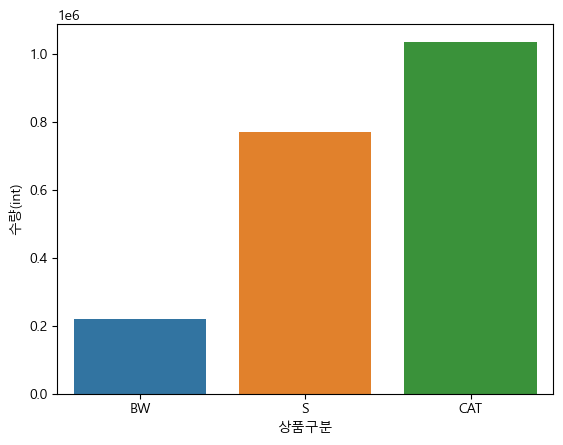

In [740]:
sns.barplot(data=df1, x='상품구분', y='수량(int)', ci=None)
sns.barplot(data=df1, x='상품구분', y='수량(int)', ci=None, estimator=sum)

In [741]:
# 5. '판매지역'에서 가장 판매수량이 많은 5개를 선별한 뒤, 5개 지역에서 가장 많이 발주된 '상품구분'항목을 확인
p1 = df1.pivot_table(index='판매지역', values='수량(int)', aggfunc='sum').sort_values(by='수량(int)', ascending=False).head(5)
top5_list = p1.index.tolist()

In [742]:
cond1 = df1['판매지역'].isin(top5_list)
df1.loc[cond1].sort_values(by='수량(int)', ascending=False)

,순번,상품코드,상품명,판매지역,수량,상품구분,수량(int)
53462,103.0,8.801860e+12,CAT2 500ml(신),(610)부천점,"3,984",CAT,3984
61167,103.0,8.801860e+12,CAT2 500ml(신),(966)성남점,"2,952",CAT,2952
53225,96.0,8.801860e+12,CAT1 1.0L,(600)안양점,"2,637",CAT,2637
57239,85.0,8.801020e+12,HGD3 500ml 캔 (202006),(930)죽전점,"2,302",S,2302
61155,91.0,8.801860e+12,CAT2 500ml,(966)성남점,"2,245",CAT,2245
...,...,...,...,...,...,...,...
56227,108.0,8.801860e+12,CAT1 48캔+신라면 멀티 [Traders],(840)월계점,0,CAT,0
56226,107.0,8.801860e+12,CAT2 250ml,(840)월계점,0,CAT,0
56225,106.0,8.801860e+12,CAT1 250ml*10*2 [Traders],(840)월계점,0,CAT,0
53434,75.0,8.801020e+12,G1 IPA 473ml*6캔 [Traders],(610)부천점,0,S,0


In [743]:
# 6. '판매지역'에 'E/T'값이 포함된 항목과 'NB'값이 포함된 항목을 구분하여, 두 항목간 발주수량의 평균의 차이가 있는지 검정
def func3(row) :
    if 'E/T' in row :
        return 'E/T'
    elif 'NB' in row :
        return 'NB'
    else :
        return 'other'

df1['판매지역구분'] = df1['판매지역'].apply(func3)

In [744]:
cond1 = df1['판매지역구분'].isin(['E/T', 'NB'])
df2 = df1.loc[cond1]

In [745]:
# (범주형 vs 연속형 -> 평균검정)
# 6-1. 수량 데이터의 분포가 정규분포를 따르는가? (귀무 : 정규분포 / 대립 : 정규분포X)
stats.normaltest(df2['수량(int)'])

NormaltestResult(statistic=68286.2778925072, pvalue=0.0)

In [746]:
cond1 = df2['판매지역구분'] == 'E/T'
cond2 = df2['판매지역구분'] == 'NB'
df2_ET = df2.loc[cond1]
df2_NB = df2.loc[cond2]

In [747]:
# 6-2. 정규분포를 따르지 않는 수량값의 평균의 차이가 두 집단에 따라 발생하는가?
# 귀무가설 : 두 집단의 수량의 평균의 차이가 없다
# 대립가설 : 두 집단의 수량의 평균의 차이가 있다.
stats.ranksums(df2_ET['수량(int)'], df2_NB['수량(int)'])
# p.value < 0.05 / 대립가설 참 /두 집단의 수량 데이터의 평균의 차이가 있다.

RanksumsResult(statistic=8.936132156072583, pvalue=4.030299153195065e-19)

In [748]:
# 7. '판매지역'에 따른 '수량'의 '평균'/'합'/'최대'/'최소'값을 계산
df1.pivot_table(index='판매지역', values='수량(int)', aggfunc=['mean','sum','max','min'])

,mean,sum,max,min
,수량(int),수량(int),수량(int),수량(int)
판매지역,,,,
(1154)의정부점,59.382609,6829,651,0
(1155)별내점,72.817391,8374,850,0
(1156)풍산점,109.791304,12626,1218,0
(1157)김포한강점,102.321739,11767,1130,0
(1158)세종점,94.886957,10912,980,0
...,...,...,...,...
(L38)율전점,15.495652,1782,430,0
(L39)본오점,27.208696,3129,1422,0


In [749]:
# 8. '판매수량'이 가장 높은 상위 3개의 품목을 확인
df1.pivot_table(index='상품명', values='수량(int)', aggfunc='sum').sort_values('수량(int)', ascending=False).head(3)

,수량(int)
상품명,
CAT2 500ml,194889
CAT2 500ml(신),163233
CAT2 1.6L,125144


# 비지도 학습
- X(설명변수)들 간의 관계(유사성, 연관성, 기하거리)을 이용해서 비슷한 데이터를 묶어주거나, 유사한 데이터를 확인, 차원을 줄여주는 등의 학습 기법
    - 1. 군집분석(Clustering)
    - 2. 연관분석(Association Analysis) : 각각의 데이터의 유사도를 계산하여, 비슷한 데이터들을 찾거나 확인하는 분석
    - 3. 차원축소(PCA, 주성분분석) : 여러가지 항목들을 수학적 기법을 활용해 적은 차원으로 줄여주는 방법
- **Clustering(군집분석)** 
    - 계층형 군집분석 : 병합 또는 분할 기법을 이용해 가까운(또는 먼) 위치의 데이터를 묶어 나가며 군집을 형성하는 기법
    - 비계층형 군집분석 : 데이터 간의 거리나 데이터의 밀도를 이용해 군집을 구성
        / 사용자가 군집수를 직접 지정 / k-mean
    - 잠재공간 군집분석 : 잠재 공간으로 부터 추정된 값을 이용해 군집을 구성

In [750]:
from sklearn.cluster import AgglomerativeClustering     # 병합형 계층 군집분석

In [318]:
df1 = pd.read_csv('06_Data.csv')

In [320]:
X = df1[['Mean Radius', 'Mean Perimeter', 'Mean Area', 'Mean Texture']]

In [321]:
cluster = AgglomerativeClustering()
cluster.fit(X)

AgglomerativeClustering()

In [323]:
X['cluster'] = cluster.fit_predict(X)

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_23296\1088527410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = cluster.fit_predict(X)


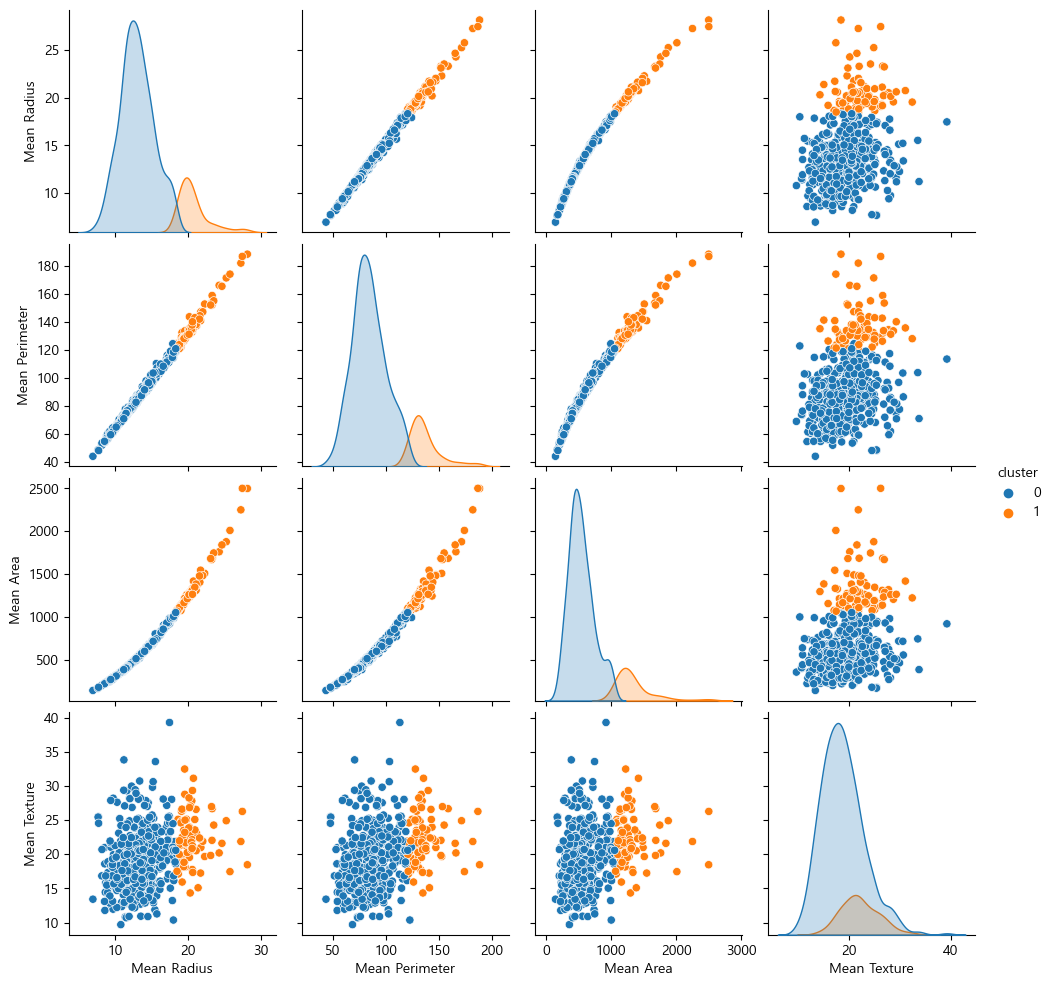

In [324]:
sns.pairplot(data=X, hue='cluster')

In [751]:
from sklearn.cluster import KMeans

In [326]:
cluster = KMeans(n_clusters=4)
cluster.fit(X)

KMeans(n_clusters=4)

In [330]:
X['kmeans_cluster'] = cluster.fit_predict(X)
X['kmeans_cluster'].value_counts()

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_23296\1884108107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['kmeans_cluster'] = cluster.fit_predict(X)


1    268
3    186
0    102
2     13
Name: kmeans_cluster, dtype: int64

c:\Python310\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


c:\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


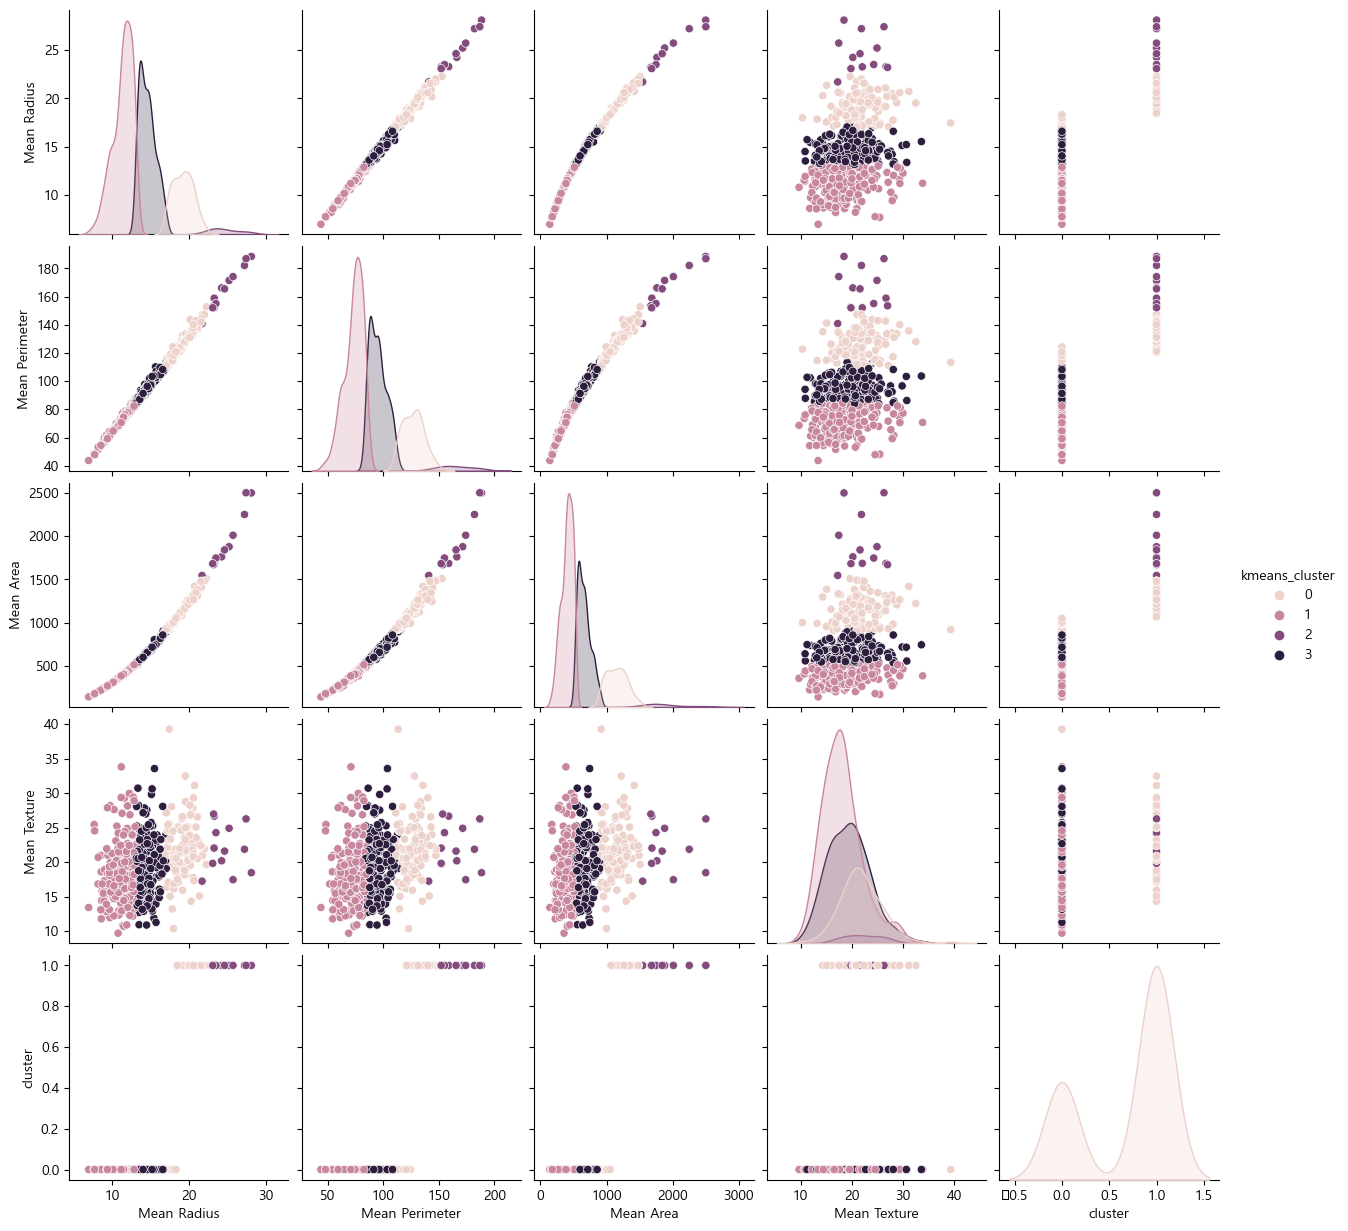

In [331]:
sns.pairplot(data=X, hue='kmeans_cluster')

# 실루엣 분석
- 실루엣 값 : 같은 군집 내 데이터가 얼마나 잘 모여있는가, 서로 다른 군집끼리 데이터가 얼마나 떨어져 있는가를 수치화한 지표 / **참고 지표로 사용**

In [752]:
from sklearn.metrics import silhouette_score

In [334]:
X_feature = X[['Mean Radius', 'Mean Perimeter', 'Mean Area', 'Mean Texture']]

In [335]:
silhouette_score(X_feature, X['kmeans_cluster'])

0.5587597139763498

In [337]:
for i in [2,3,4,5] : 
    cluster = KMeans(n_clusters=i)
    cluster.fit(X_feature)
    X_cluster = cluster.fit_predict(X_feature)
    print(i, '개의 군집 silhouette :', silhouette_score(X_feature, X_cluster))

2 개의 군집 silhouette : 0.6991356519247057
3 개의 군집 silhouette : 0.5653581270681922
4 개의 군집 silhouette : 0.5587597139763498
5 개의 군집 silhouette : 0.543866185116349


# Mission1.

-> Store.zip 파일에 있는 1_store_member.csv 데이터와 2_store_product.csv 데이터로 아래와 같은 미션을 수행하고자 한다.
1) 1_store_member.csv 데이터를 df_member, 2_store_product.csv 데이터를 df_product로 선언하고, 데이터 구조와 타입을 각각 확인하시오.
2) df_product 데이터에서 고객 한명 당 '총구매금액' / '총구매수량' / '방문횟수' / '주당방문횟수' / '1회방문시구매금액'을 계산하고, 계산된 Table을 df_product_m1으로 선언하시오.
3) df_member데이터와 df_product_m1를 '회원번호'를 기준으로 병합하고, df1으로 선언하시오.
4) df1 데이터에서 주소지의 빈도수가 전체 중 50%에 해당하는 지역을 A / 나머지 30% (빈도수의 70%)를 B / 나머지 지역을 C로 나누어 '지역등급'이라는 항목으로 선언하시오.
5) '연령'데이터를 이용하여 25세 미만은 '20대초반' / 25세이상 ~ 40세 미만을 '30대' / 40세 이상 55세 미만을 '40대' / 55세 이상은 '50대이상'으로 구분하시오.
6) df_product 데이터를 이용해 회원 별 '물품대분류'의 구매수량 비율을 각 항목별로 계산하여, df1데이터에 병합하시오 (index -> 회원번호 / columns -> 물품대분류 / value -> 한명의 회원이 해당 품목을 구매한 비율)
7) '성별'에 따라 '1회방문시구매금액'의 평균의 차이가 있는지 시각화 및 검정하시오.
8) df1데이터에서, '총구매금액' / '총구매수량' / '총방문횟수' / '주당방문횟수' / '1회방문시구매금액'데이터를 이용하여, Kmeans Clustering 분석을 통해 3군집/4군집/5군집/6군집에서 실루엣 값을 계산 하시오.
9) Kmeans Clustering을 통해 df1데이터를 4개 군집으로 나누고 ('총구매금액'/'총구매수량'을 활용) 각 군집을 A/B/C/D 값으로 변환해 'Target'이름의 항목으로 선언하시오.
10) '성별'/'연령'/'지역등급'/'결혼유무'/'1회방문시구매금액'을 X로, 'Target'을 분류하는 분류모델을 Ensemble 알고리즘의 RandomForestClassifier를 활용하여 분류모델을 생성, 평가 후 'model_RF.sav' 이름으로 저장하시오.

## 1번

In [641]:
# 1) 1_store_member.csv 데이터를 df_member, 2_store_product.csv 데이터를 df_product로 선언하고, 데이터 구조와 타입을 각각 확인하시오.

df_member = pd.read_csv('1_store_member.csv')
df_product = pd.read_csv('2_store_product.csv')

In [642]:
df_member.info()
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4396 entries, 0 to 4395
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회원번호    4396 non-null   int64 
 1   회원상태    4396 non-null   object
 2   성별      4396 non-null   object
 3   결혼유무    3449 non-null   object
 4   주소      4396 non-null   object
 5   생년      4396 non-null   int64 
 6   연령      4396 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 240.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735783 entries, 0 to 735782
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   공급일자      735783 non-null  int64  
 1   물품코드      735783 non-null  int64  
 2   물품대분류     735783 non-null  object 
 3   물품중분류     735783 non-null  object 
 4   물품소분류     735783 non-null  object 
 5   물품명       735783 non-null  object 
 6   구매수량      735783 non-null  float64
 7   구매금액      735783 non-null  int64  
 8   구매

## 2번

In [643]:
# 2) df_product 데이터에서 고객 한명 당 '총구매금액' / '총구매수량' / '방문횟수' / '주당방문횟수' / '1회방문시구매금액'을 계산하고, 
# 계산된 Table을 df_product_m1으로 선언하시오.

In [644]:
# df_product['datetime'] = pd.to_datetime(df_product['공급일자'].astype(str))
# df_product['month'] = df_product['datetime'].dt.month
# df_product['week'] = df_product['datetime'].dt.isocalendar().week

# df_product_m1 = df_product.pivot_table(index='회원번호', values=['구매금액','구매수량','방문횟수'], aggfunc='sum')
# df_product_m1['1회방문시구매금액'] = df_product_m1['구매금액']/df_product_m1['방문횟수']
# df_product_m1['주당방문횟수'] = df_product.pivot_table(index='회원번호', values=['week'], aggfunc='sum')

In [645]:
df_product['공급주차'] = pd.to_datetime(df_product['공급일자'],
                                    format='%Y%m%d').dt.isocalendar().week
df_product['공급주차'].describe()

count    735783.000000
mean         13.565960
std           7.487991
min           1.000000
25%           7.000000
50%          14.000000
75%          20.000000
max          26.000000
Name: 공급주차, dtype: float64

In [646]:
df_product['방문횟수'] = 1
p1 = df_product.pivot_table(index=['회원번호', '공급일자'], values='방문횟수', aggfunc='min').reset_index()
p2 = p1.pivot_table(index='회원번호', values='방문횟수', aggfunc='sum').reset_index()
p2['주당방문횟수'] = (p2['방문횟수']/26)

In [647]:
p3 = df_product.pivot_table(index='회원번호', 
                       values=['구매금액','구매수량'],aggfunc='sum').reset_index()

In [648]:
df_product_m0 = pd.merge(p3, p2, on='회원번호',how='left')
df_product_m1= df_product_m0.rename(columns={'구매금액':'총구매금액',
                                             '구매수량':'총구매수량',
                                             '방문횟수':'총방문횟수'})
df_product_m1['1회방문시구매금액'] = df_product_m1['총구매금액'] / df_product_m1['총방문횟수']
df_product_m1.head()

,회원번호,총구매금액,총구매수량,총방문횟수,주당방문횟수,1회방문시구매금액
0,2101.0,1991230,382.0,86,3.307692,23153.837209
1,2102.0,2095860,472.5,79,3.038462,26529.873418
2,2103.0,8273550,1675.4,126,4.846154,65663.095238
3,2104.0,6289495,1401.8,125,4.807692,50315.960000
4,2105.0,3067930,602.0,57,2.192308,53823.333333


In [649]:
# p2['총구매금액'] = df_product.pivot_table(index='회원번호', values='구매금액', aggfunc='sum').values
# p2['총구매수량'] = df_product.pivot_table(index='회원번호', values='구매수량', aggfunc='sum').values
# p2['1회방문시구매금액'] = p2['총구매금액']/p2['방문횟수']

## 3번

In [650]:
# 3) df_member데이터와 df_product_m1를 '회원번호'를 기준으로 병합하고, df1으로 선언하시오.  
df1 = pd.merge(df_member, df_product_m1, on='회원번호',how='left')
df1.head(3)

,회원번호,회원상태,성별,결혼유무,주소,생년,연령,총구매금액,총구매수량,총방문횟수,주당방문횟수,1회방문시구매금액
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,1991230.0,382.0,86.0,3.307692,23153.837209
1,2102,정상회원,여,NaN,경기 용인시 수지구 동천동,1947,71,2095860.0,472.5,79.0,3.038462,26529.873418
2,2103,정상회원,여,기혼,경기 용인시 수지구 동천동,1972,46,8273550.0,1675.4,126.0,4.846154,65663.095238


## 4번

In [651]:
# 4) df1 데이터에서 주소지의 빈도수가 전체 중 
# 50%에 해당하는 지역을 A / 나머지 30% (빈도수의 70%)를 B / 나머지 지역을 C로 나누어 '지역등급'이라는 항목으로 선언하시오.

def func4(row) : 
    if '경기' in row :
        return row.split(' ')[2]
    elif '서울' in row :
        return row.split(' ')[1]
    else :
        return row

df_address = pd.DataFrame(df1['주소'].apply(func4).value_counts())
df_address['비율'] = (df_address['주소'] / df_address['주소'].sum())
df_address2 = df_address.sort_values(by='비율', ascending=False)
df_address2['누적비율'] = df_address2['비율'].cumsum()
df_address2

,주소,비율,누적비율
수지구,1776,0.404004,0.404004
분당구,506,0.115105,0.519108
기흥구,442,0.100546,0.619654
강남구,165,0.037534,0.657188
영통구,144,0.032757,0.689945
...,...,...,...
경북 문경시 흥덕동 776,1,0.000227,0.999090
세종 종촌동 649번지 가,1,0.000227,0.999318
재궁동,1,0.000227,0.999545
세종 어진동 세종더?센트럴,1,0.000227,0.999773


In [652]:
df_member['주소구분'] = df_member['주소'].apply(func4)

In [653]:
cond1 = df_member['주소구분'].isin(df_address2.loc[(df_address2['누적비율']<=0.70)].index.tolist())
cond2 = df_member['주소구분'].isin(df_address2.loc[(df_address2['누적비율']<=0.50)].index.tolist())
df_member['지역등급'] = 'C'
df_member.loc[cond1, '지역등급'] = 'B'
df_member.loc[cond2, '지역등급'] = 'A'
df_member['지역등급'].value_counts()

A    1776
C    1363
B    1257
Name: 지역등급, dtype: int64

In [654]:
df_member

,회원번호,회원상태,성별,결혼유무,주소,생년,연령,주소구분,지역등급
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,강북구,C
1,2102,정상회원,여,NaN,경기 용인시 수지구 동천동,1947,71,수지구,A
2,2103,정상회원,여,기혼,경기 용인시 수지구 동천동,1972,46,수지구,A
3,2104,정상회원,여,NaN,경기 용인시 수지구 성복동,1969,49,수지구,A
4,2105,정상회원,여,기혼,경기 용인시 수지구 동천동,1948,70,수지구,A
...,...,...,...,...,...,...,...,...,...
4391,6492,정상회원,여,미혼,경기 성남시 분당구 판교동,1963,55,분당구,B
4392,6493,정상회원,여,기혼,서울 관악구 행운동 1681,1982,36,관악구,C
4393,6494,정상회원,남,기혼,경기 성남시 분당구 백현동,1975,43,분당구,B
4394,6495,정상회원,여,기혼,서울 용산구 한남동 737-,1961,57,용산구,C


## 5번

In [655]:
# 5) '연령'데이터를 이용하여 
# 25세 미만은 '20대초반' / 25세이상 ~ 40세 미만을 '30대' / 40세 이상 55세 미만을 '40대' / 55세 이상은 '50대이상'으로 구분하시오.
df_member['연령']

0       51
1       71
2       46
3       49
4       70
        ..
4391    55
4392    36
4393    43
4394    57
4395    47
Name: 연령, Length: 4396, dtype: int64

In [656]:
def func5(row) : 
    if row >= 55 :
        return '50대이상'
    elif row >= 40 :
        return '40대'
    elif row >= 25 :
        return '30대'
    else :
        return '20대초반'

df_member['연령대'] = df_member['연령'].apply(func5)
df_member

,회원번호,회원상태,성별,결혼유무,주소,생년,연령,주소구분,지역등급,연령대
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,강북구,C,40대
1,2102,정상회원,여,NaN,경기 용인시 수지구 동천동,1947,71,수지구,A,50대이상
2,2103,정상회원,여,기혼,경기 용인시 수지구 동천동,1972,46,수지구,A,40대
3,2104,정상회원,여,NaN,경기 용인시 수지구 성복동,1969,49,수지구,A,40대
4,2105,정상회원,여,기혼,경기 용인시 수지구 동천동,1948,70,수지구,A,50대이상
...,...,...,...,...,...,...,...,...,...,...
4391,6492,정상회원,여,미혼,경기 성남시 분당구 판교동,1963,55,분당구,B,50대이상
4392,6493,정상회원,여,기혼,서울 관악구 행운동 1681,1982,36,관악구,C,30대
4393,6494,정상회원,남,기혼,경기 성남시 분당구 백현동,1975,43,분당구,B,40대
4394,6495,정상회원,여,기혼,서울 용산구 한남동 737-,1961,57,용산구,C,50대이상


## 6번

In [657]:
# 6) df_product 데이터를 이용해 회원 별 '물품대분류'의 구매수량 비율을 각 항목별로 계산하여, 
# df1데이터에 병합하시오 (index -> 회원번호 / columns -> 물품대분류 / value -> 한명의 회원이 해당 품목을 구매한 비율)
df_product.head(3)

,공급일자,물품코드,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,반품_원거래일자,회원번호,공급주차,방문횟수
0,20170201,50142001,채소,잎/줄기채소,시금치,시금치(300g),1.0,2000,매장3,NaN,2101.0,5,1
1,20170201,60302012,축산물,육가공,돈가스/분쇄가공,튀김옷돈가스(400g),1.0,6300,매장3,NaN,2101.0,5,1
2,20170201,80301002,간식,밀가공,라면,감자라면(110g:1봉),2.0,2600,매장3,NaN,2101.0,5,1


In [658]:
df_product2 = df_product.pivot_table(index='회원번호', values='구매수량', columns='물품대분류', aggfunc='mean').reset_index()
df_product2

물품대분류,회원번호,간식,건강,과실,급식용,기타,반찬,베이커리,생활용품,서류,수산,양념/가루,음료,잡곡,주곡,주류,채소,축산물
0,2101.0,1.111111,2.250000,1.000000,NaN,NaN,1.264151,NaN,1.142857,1.0,1.000000,1.363636,2.000000,1.000000,1.0,NaN,0.967213,1.078652
1,2102.0,1.318584,NaN,1.017241,NaN,NaN,1.272727,NaN,0.750000,1.0,1.333333,1.133333,1.000000,1.000000,1.0,NaN,1.019608,1.133333
2,2103.0,1.103891,0.570968,0.940000,NaN,NaN,1.139037,NaN,1.113208,1.0,1.012821,1.050847,1.150000,1.000000,1.0,1.0,1.004283,1.083333
3,2104.0,1.397590,0.800000,0.900000,NaN,NaN,1.324503,NaN,0.928571,1.0,1.367816,1.053571,1.227586,1.000000,1.0,1.0,1.105405,1.192308
4,2105.0,1.219178,4.000000,1.148148,NaN,NaN,1.381818,NaN,1.000000,1.0,1.160000,1.086957,1.458333,0.933333,1.0,NaN,1.044586,1.212500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280,6492.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
4281,6493.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000
4282,6494.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4283,6495.0,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [659]:
df2 = pd.merge(df1, df_product2, on='회원번호', how='inner')

## 7번

In [660]:
# 7) '성별'에 따라 '1회방문시구매금액'의 평균의 차이가 있는지 시각화 및 검정하시오.

RanksumsResult(statistic=-1.2604454656984792, pvalue=0.20750870900597662)

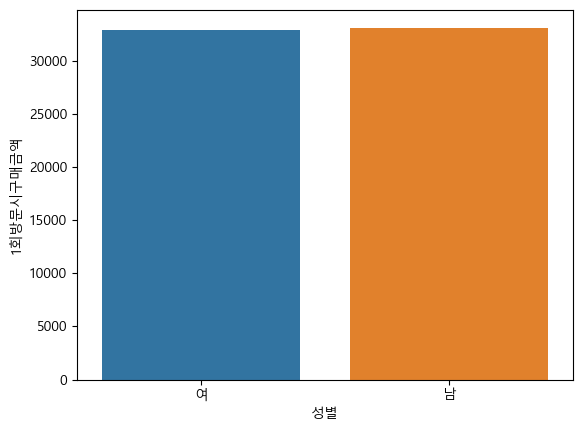

In [661]:
sns.barplot(data = df2, x = '성별', y = '1회방문시구매금액', ci=None)

cond1 = df2['성별'] == '남'
cond2 = df2['성별'] == '여'


stats.normaltest(df2['1회방문시구매금액'])
# p.value < 0.05

stats.ranksums(df2.loc[cond1]['1회방문시구매금액'],df2.loc[cond2]['1회방문시구매금액'])
# p.value > 0.05

## 8번

In [662]:
# 8) df1데이터에서, '총구매금액' / '총구매수량' / '총방문횟수' / '주당방문횟수' / '1회방문시구매금액'데이터를 이용하여, 
# Kmeans Clustering 분석을 통해 3군집/4군집/5군집/6군집에서 실루엣 값을 계산 하시오.

from sklearn.model_selection import train_test_split
from sklearn.compose        import make_column_transformer
from imblearn.pipeline      import pipeline
from imblearn.pipeline      import make_pipeline
from sklearn.impute         import SimpleImputer, KNNImputer
from sklearn.preprocessing  import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier # Bagging Model 
from sklearn.model_selection import GridSearchCV    # 교차검증
from sklearn.metrics   import classification_report     # 평가
import pickle


In [663]:
df1

,회원번호,회원상태,성별,결혼유무,주소,생년,연령,총구매금액,총구매수량,총방문횟수,주당방문횟수,1회방문시구매금액
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,1991230.0,382.0,86.0,3.307692,23153.837209
1,2102,정상회원,여,NaN,경기 용인시 수지구 동천동,1947,71,2095860.0,472.5,79.0,3.038462,26529.873418
2,2103,정상회원,여,기혼,경기 용인시 수지구 동천동,1972,46,8273550.0,1675.4,126.0,4.846154,65663.095238
3,2104,정상회원,여,NaN,경기 용인시 수지구 성복동,1969,49,6289495.0,1401.8,125.0,4.807692,50315.960000
4,2105,정상회원,여,기혼,경기 용인시 수지구 동천동,1948,70,3067930.0,602.0,57.0,2.192308,53823.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
4391,6492,정상회원,여,미혼,경기 성남시 분당구 판교동,1963,55,51550.0,10.0,1.0,0.038462,51550.000000
4392,6493,정상회원,여,기혼,서울 관악구 행운동 1681,1982,36,22500.0,3.0,1.0,0.038462,22500.000000
4393,6494,정상회원,남,기혼,경기 성남시 분당구 백현동,1975,43,18500.0,3.0,1.0,0.038462,18500.000000
4394,6495,정상회원,여,기혼,서울 용산구 한남동 737-,1961,57,5300.0,1.0,1.0,0.038462,5300.000000


In [664]:
X = df1[['총구매금액', '총구매수량', '총방문횟수', '주당방문횟수', '1회방문시구매금액']].dropna()

In [665]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [666]:
for i in [3,4,5,6] : 
    cluster = KMeans(n_clusters=i)
    cluster.fit(X)
    X_cluster = cluster.fit_predict(X)
    print(i, '개의 군집 silhouette :', silhouette_score(X, X_cluster))

3 개의 군집 silhouette : 0.8189733654004079
4 개의 군집 silhouette : 0.7944429137024346
5 개의 군집 silhouette : 0.774920187698466
6 개의 군집 silhouette : 0.7454314999643713


In [667]:
df1 = df1.dropna()

## 9번

In [668]:
# 9) Kmeans Clustering을 통해 df1데이터를 4개 군집으로 나누고 ('총구매금액'/'총구매수량'을 활용) 
# 각 군집을 A/B/C/D 값으로 변환해 'Target'이름의 항목으로 선언하시오.


In [669]:
X = df1[['총구매금액', '총구매수량']]

In [670]:
cluster = KMeans(n_clusters=4)
cluster.fit(X)
X_cluster = cluster.fit_predict(X)

X['k'] = X_cluster

def func6(data) :
    if data == 0 :
        return 'A'
    elif data == 1 :
        return 'B'
    elif data == 2 :
        return 'C'
    else :
        return 'D'

df1['Target'] = X['k'].apply(func6)

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_23296\1619094242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['k'] = X_cluster
C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_23296\1619094242.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Target'] = X['k'].apply(func6)


In [671]:
df1.head()

,회원번호,회원상태,성별,결혼유무,주소,생년,연령,총구매금액,총구매수량,총방문횟수,주당방문횟수,1회방문시구매금액,Target
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,1991230.0,382.00,86.0,3.307692,23153.837209,D
2,2103,정상회원,여,기혼,경기 용인시 수지구 동천동,1972,46,8273550.0,1675.40,126.0,4.846154,65663.095238,B
4,2105,정상회원,여,기혼,경기 용인시 수지구 동천동,1948,70,3067930.0,602.00,57.0,2.192308,53823.333333,D
6,2107,정상회원,여,기혼,경기 용인시 수지구 신봉동,1941,77,7161860.0,1419.75,143.0,5.500000,50082.937063,B
9,2110,정상회원,여,기혼,경기 용인시 수지구 신봉동,1965,53,5549725.0,1204.10,145.0,5.576923,38273.965517,B


## 10번

In [672]:
# 10) '성별'/'연령'/'지역등급'/'결혼유무'/'1회방문시구매금액'을 X로, 
# 'Target'을 분류하는 분류모델을 Ensemble 알고리즘의 RandomForestClassifier를 활용하여 분류모델을 생성, 평가 후 'model_RF.sav' 이름으로 저장하시오.


In [680]:
df_member.head(2)

,회원번호,회원상태,성별,결혼유무,주소,생년,연령,주소구분,지역등급,연령대
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,강북구,C,40대
1,2102,정상회원,여,NaN,경기 용인시 수지구 동천동,1947,71,수지구,A,50대이상


In [681]:
df1.head(2)

,회원번호,회원상태,성별,결혼유무,주소,생년,연령,총구매금액,총구매수량,총방문횟수,주당방문횟수,1회방문시구매금액,Target
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,1991230.0,382.0,86.0,3.307692,23153.837209,D
2,2103,정상회원,여,기혼,경기 용인시 수지구 동천동,1972,46,8273550.0,1675.4,126.0,4.846154,65663.095238,B


In [677]:
df_10 = pd.merge(df1, df_member, left_on='주소',right_on='주소',how='inner')

In [678]:
df_10.columns

Index(['회원번호_x', '회원상태_x', '성별_x', '결혼유무_x', '주소', '생년_x', '연령_x', '총구매금액',
       '총구매수량', '총방문횟수', '주당방문횟수', '1회방문시구매금액', 'Target', '회원번호_y', '회원상태_y',
       '성별_y', '결혼유무_y', '생년_y', '연령_y', '주소구분', '지역등급', '연령대'],
      dtype='object')

In [679]:
# 1. X/Y를 선언한다
Y = df_10['Target']     # wafer 폐기 여부를 분류하는 알고리즘을 구성
X = df_10[['성별_x', '연령_x', '지역등급', '결혼유무_x', '1회방문시구매금액']]

In [682]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

In [683]:
# 4. 파이프라인을 구성한다.
numeric_pipe = make_pipeline(KNNImputer(), MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
numeric_list = X.describe().columns.tolist()
category_list = X.describe(include='object').columns.tolist()
preprocessing_pipe = make_column_transformer((numeric_pipe, numeric_list)
                                            , (category_pipe, category_list))
model_pipe = make_pipeline(preprocessing_pipe, ADASYN(), RandomForestClassifier())

In [685]:
# 5. 교차검증 및 하이퍼 파라미터 튜닝
hyperparameter_list = {'randomforestclassifier__max_depth':range(5,11)
                        , 'randomforestclassifier__min_samples_leaf':range(5,11)
                        , 'randomforestclassifier__min_samples_split':range(5,11)}
grid_model = GridSearchCV(model_pipe, param_grid={}
                            , cv=5, n_jobs=-1, scoring='f1')
grid_model.fit(X_train, Y_train)

c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DMC CONET\AppData\Roaming\Python\Python310\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\DMC CONET\AppData\Roaming\Python\Python310\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  F

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['연령_x',
                                                                          '1회방문시구매금액']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['성별_x',
                                                                          '지역등급',
                                                                          '결혼유무_x'])])),
                                       ('adasyn', ADASYN()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1, param_grid={}, scoring='f1')

In [686]:
# 6. 평가
best_model = grid_model.best_estimator_

Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

In [687]:
print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00    103935
           B       1.00      1.00      1.00     21510
           C       1.00      1.00      1.00      3252
           D       1.00      1.00      1.00     42623

    accuracy                           1.00    171320
   macro avg       1.00      1.00      1.00    171320
weighted avg       1.00      1.00      1.00    171320



In [688]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00     44182
           B       1.00      1.00      1.00      9171
           C       1.00      1.00      1.00      1431
           D       1.00      1.00      1.00     18639

    accuracy                           1.00     73423
   macro avg       1.00      1.00      1.00     73423
weighted avg       1.00      1.00      1.00     73423



In [ ]:
pickle.dump(best_model, open('model_RF.sav','wb'))

## 강사님

In [829]:
# 1) 1_store_member.csv 데이터를 df_member, 2_store_product.csv 데이터를 df_product로 선언하고, 데이터 구조와 타입을 각각 확인하시오.

df_member = pd.read_csv('1_store_member.csv')
df_product = pd.read_csv('2_store_product.csv')

In [830]:
df_member.info()
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4396 entries, 0 to 4395
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회원번호    4396 non-null   int64 
 1   회원상태    4396 non-null   object
 2   성별      4396 non-null   object
 3   결혼유무    3449 non-null   object
 4   주소      4396 non-null   object
 5   생년      4396 non-null   int64 
 6   연령      4396 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 240.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735783 entries, 0 to 735782
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   공급일자      735783 non-null  int64  
 1   물품코드      735783 non-null  int64  
 2   물품대분류     735783 non-null  object 
 3   물품중분류     735783 non-null  object 
 4   물품소분류     735783 non-null  object 
 5   물품명       735783 non-null  object 
 6   구매수량      735783 non-null  float64
 7   구매금액      735783 non-null  int64  
 8   구매

In [831]:
# 2) df_product 데이터에서 고객 한명 당 '총구매금액' / '총구매수량' / '방문횟수' / '주당방문횟수' / '1회방문시구매금액'을 계산하고, 
# 계산된 Table을 df_product_m1으로 선언하시오.

In [832]:
df_product['공급주차'] = pd.to_datetime(df_product['공급일자'],
                                    format='%Y%m%d').dt.isocalendar().week
df_product['공급주차'].describe()

count    735783.000000
mean         13.565960
std           7.487991
min           1.000000
25%           7.000000
50%          14.000000
75%          20.000000
max          26.000000
Name: 공급주차, dtype: float64

In [833]:
df_product['방문횟수'] = 1
p1 = df_product.pivot_table(index=['회원번호', '공급일자'], values='방문횟수', aggfunc='min').reset_index()
p2 = p1.pivot_table(index='회원번호', values='방문횟수', aggfunc='sum').reset_index()
p2['주당방문횟수'] = (p2['방문횟수']/26)

In [834]:
p3 = df_product.pivot_table(index='회원번호', 
                       values=['구매금액','구매수량'],aggfunc='sum').reset_index()

In [835]:
df_product_m0 = pd.merge(p3, p2, on='회원번호',how='left')
df_product_m1= df_product_m0.rename(columns={'구매금액':'총구매금액',
                                             '구매수량':'총구매수량',
                                             '방문횟수':'총방문횟수'})
df_product_m1['1회방문시구매금액'] = df_product_m1['총구매금액'] / df_product_m1['총방문횟수']
df_product_m1.head()

,회원번호,총구매금액,총구매수량,총방문횟수,주당방문횟수,1회방문시구매금액
0,2101.0,1991230,382.0,86,3.307692,23153.837209
1,2102.0,2095860,472.5,79,3.038462,26529.873418
2,2103.0,8273550,1675.4,126,4.846154,65663.095238
3,2104.0,6289495,1401.8,125,4.807692,50315.960000
4,2105.0,3067930,602.0,57,2.192308,53823.333333


In [856]:
# 3) df_member데이터와 df_product_m1를 '회원번호'를 기준으로 병합하고, df1으로 선언하시오.  
df1 = pd.merge(df_member, df_product_m1, on='회원번호',how='left')
df1.head(3)

,회원번호,회원상태,성별,결혼유무,주소,생년,연령,주소구분,지역등급,총구매금액,총구매수량,총방문횟수,주당방문횟수,1회방문시구매금액
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,강북구,C,1991230.0,382.0,86.0,3.307692,23153.837209
1,2102,정상회원,여,NaN,경기 용인시 수지구 동천동,1947,71,수지구,A,2095860.0,472.5,79.0,3.038462,26529.873418
2,2103,정상회원,여,기혼,경기 용인시 수지구 동천동,1972,46,수지구,A,8273550.0,1675.4,126.0,4.846154,65663.095238


In [857]:
# 4) df1 데이터에서 주소지의 빈도수가 전체 중 
# 50%에 해당하는 지역을 A / 나머지 30% (빈도수의 70%)를 B / 나머지 지역을 C로 나누어 '지역등급'이라는 항목으로 선언하시오.

def func4(row):
    if '경기' in row:
        return row.split(' ')[2]
    elif '서울' in row:
        return row.split(' ')[1]
    return row 

df_address = pd.DataFrame(df_member['주소'].apply(func4).value_counts())
df_address['비율'] = (df_address['주소'] / df_address['주소'].sum())
df_address2 = df_address.sort_values(by='비율',ascending=False)
df_address2['누적비율'] = df_address2['비율'].cumsum()
df_address2


,주소,비율,누적비율
수지구,1776,0.404004,0.404004
분당구,506,0.115105,0.519108
기흥구,442,0.100546,0.619654
강남구,165,0.037534,0.657188
영통구,144,0.032757,0.689945
...,...,...,...
경북 문경시 흥덕동 776,1,0.000227,0.999090
세종 종촌동 649번지 가,1,0.000227,0.999318
재궁동,1,0.000227,0.999545
세종 어진동 세종더?센트럴,1,0.000227,0.999773


In [858]:
df1['주소구분']= df1['주소'].apply(func4)


In [859]:
cond1 = df_member['주소구분'].isin(df_address2.loc[(df_address2['누적비율']<=0.70)].index.tolist())
cond2 = df_member['주소구분'].isin(df_address2.loc[(df_address2['누적비율']<=0.50)].index.tolist())
df1['지역등급']='C'
df1.loc[cond1, '지역등급']='B'
df1.loc[cond2, '지역등급']='A'
df1['지역등급'].value_counts()


A    1776
C    1363
B    1257
Name: 지역등급, dtype: int64

In [860]:
df_member

,회원번호,회원상태,성별,결혼유무,주소,생년,연령,주소구분,지역등급
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,강북구,C
1,2102,정상회원,여,NaN,경기 용인시 수지구 동천동,1947,71,수지구,A
2,2103,정상회원,여,기혼,경기 용인시 수지구 동천동,1972,46,수지구,A
3,2104,정상회원,여,NaN,경기 용인시 수지구 성복동,1969,49,수지구,A
4,2105,정상회원,여,기혼,경기 용인시 수지구 동천동,1948,70,수지구,A
...,...,...,...,...,...,...,...,...,...
4391,6492,정상회원,여,미혼,경기 성남시 분당구 판교동,1963,55,분당구,B
4392,6493,정상회원,여,기혼,서울 관악구 행운동 1681,1982,36,관악구,C
4393,6494,정상회원,남,기혼,경기 성남시 분당구 백현동,1975,43,분당구,B
4394,6495,정상회원,여,기혼,서울 용산구 한남동 737-,1961,57,용산구,C


In [861]:
# 5) '연령'데이터를 이용하여 
# 25세 미만은 '20대초반' / 25세이상 ~ 40세 미만을 '30대' / 40세 이상 55세 미만을 '40대' / 55세 이상은 '50대이상'으로 구분하시오.
cond1 = (df1['연령']>= 55)
cond2 = (df1['연령']>= 40)
cond3 = (df1['연령']>= 25)

df1['연령구분']='20대초반'
df1.loc[cond3,'연령구분']='30대'
df1.loc[cond2,'연령구분']='40대'
df1.loc[cond1,'연령구분']='50대이상'
df1['연령구분'].value_counts()


40대      1868
50대이상    1596
30대       928
20대초반       4
Name: 연령구분, dtype: int64

In [864]:
# 6) df_product 데이터를 이용해 회원 별 '물품대분류'의 구매수량 비율을 각 항목별로 계산하여, 
# df1데이터에 병합하시오 (index -> 회원번호 / columns -> 물품대분류 / value -> 한명의 회원이 해당 품목을 구매한 비율)

df_product['물품대분류'].value_counts()
p1 = df_product.pivot_table(index='회원번호', values='구매수량'
                            , columns='물품대분류', aggfunc='sum'
                            , margins=True, fill_value=0)  # margin 합계를 구할 때 사용, fill_value 비어있는 값을 대체

p1_category_list = p1.columns.tolist()[:-1]
for i in p1_category_list : 
    p1[i+'(%)'] = p1[i] / p1['All']

p1

In [865]:
p2 = p1[p1.columns.tolist()[18:]].reset_index().iloc[:-1]
p2['회원번호(float)'] = p2['회원번호'].astype(float)


In [867]:
df1_m = pd.merge(df1, p2, left_on='회원번호', right_on='회원번호(float)', how='left')
df1_m.head()

,회원번호_x,회원상태,성별,결혼유무,주소,생년,연령,주소구분,지역등급,총구매금액,...,서류(%),수산(%),양념/가루(%),음료(%),잡곡(%),주곡(%),주류(%),채소(%),축산물(%),회원번호(float)
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,강북구,C,1991230.0,...,0.015707,0.010471,0.039267,0.026178,0.013089,0.005236,0.000000,0.308901,0.251309,2101.0
1,2102,정상회원,여,NaN,경기 용인시 수지구 동천동,1947,71,수지구,A,2095860.0,...,0.023280,0.050794,0.035979,0.014815,0.010582,0.033862,0.000000,0.220106,0.107937,2102.0
2,2103,정상회원,여,기혼,경기 용인시 수지구 동천동,1972,46,수지구,A,8273550.0,...,0.012534,0.094306,0.037006,0.041184,0.008356,0.007162,0.001791,0.279933,0.147427,2103.0
3,2104,정상회원,여,NaN,경기 용인시 수지구 성복동,1969,49,수지구,A,6289495.0,...,0.012127,0.084891,0.042089,0.025396,0.009274,0.011414,0.000713,0.291768,0.154801,2104.0
4,2105,정상회원,여,기혼,경기 용인시 수지구 동천동,1948,70,수지구,A,3067930.0,...,0.024917,0.048173,0.041528,0.058140,0.023256,0.009967,0.000000,0.272425,0.161130,2105.0


<AxesSubplot:xlabel='성별', ylabel='1회방문시구매금액'>

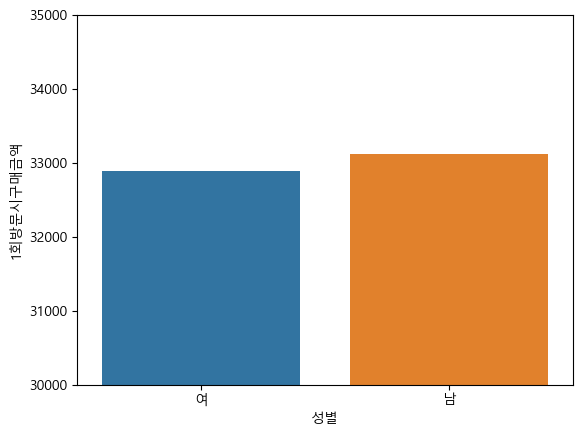

In [868]:
# 7) '성별'에 따라 '1회방문시구매금액'의 평균의 차이가 있는지 시각화 및 검정하시오.
plt.ylim([30000, 35000])
sns.barplot(data=df1_m, x='성별', y='1회방문시구매금액', ci=None)

In [869]:
df1_m.pivot_table(index='성별', values='1회방문시구매금액', aggfunc='median')

,1회방문시구매금액
성별,
남,25961.304348
여,27262.500000


In [870]:
# 7-1) '1회방문시구매금액' 데이터 분포가 정규분포를 따르는가?
# 귀무가설 : '1회방문시구매금액' 데이터는 정규성을 따른다.
# 대립가설 : '1회방문시구매금액' 데이터는 정규성을 따르지 않는다.
stats.normaltest(df1_m['1회방문시구매금액'].dropna())
# p.value < 0.05 / 대립가설 참 / 비정규

NormaltestResult(statistic=2515.0965751658086, pvalue=0.0)

In [871]:
# 7-2) 정규분포를 따르지 않는 데이터에서, 성별에 따른 1회방문시구매금액의 평균의 차이?
# 귀무 : 집단 간 평균의 차이가 있다.
# 대립 : 집단 간 평균의 차이가 없다.

df1_m1 = df1_m[['성별', '1회방문시구매금액']].dropna()

df1_man = df1_m1.loc[(df1_m1['성별']=='남')]
df1_woman = df1_m1.loc[(df1_m1['성별']=='여')]

stats.ranksums(df1_man['1회방문시구매금액'], df1_woman['1회방문시구매금액'])
# p.value > 0.05 / 귀무가설 참 /집단 간 평균의 차이가 없다

RanksumsResult(statistic=-1.2604454656984792, pvalue=0.20750870900597662)

In [872]:
# 8) df1데이터에서, '총구매금액' / '총구매수량' / '총방문횟수' / '주당방문횟수' / '1회방문시구매금액'데이터를 이용하여, 
# Kmeans Clustering 분석을 통해 3군집/4군집/5군집/6군집에서 실루엣 값을 계산 하시오.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df1_clean = df1_m[['총구매금액', '총구매수량', '총방문횟수', '주당방문횟수', '1회방문시구매금액']].dropna()

In [873]:
for i in [3,4,5,6] : 
    cluster = KMeans(n_clusters=i)
    cluster.fit(df1_clean)
    cluster_pred = cluster.fit_predict(df1_clean)
    print(i, '군집의 실루엣 값 : ', silhouette_score(df1_clean, cluster_pred))

3 군집의 실루엣 값 :  0.8189733654004079
4 군집의 실루엣 값 :  0.7927686261864565
5 군집의 실루엣 값 :  0.7744508403735897
6 군집의 실루엣 값 :  0.7471710267850434


In [874]:
# 9) Kmeans Clustering을 통해 df1데이터를 4개 군집으로 나누고 
# ('총구매금액'/'총구매수량'을 활용) 각 군집을 A/B/C/D 값으로 변환해 'Target'이름의 항목으로 선언하시오.

df1_clean2 = df1_m.dropna()

cluster = KMeans(n_clusters=4)
cluster.fit(df1_clean2[['총구매금액','총구매수량']])
df1_clean2['cluster'] = cluster.fit_predict(df1_clean2[['총구매금액','총구매수량']])
df1_clean2['cluster'].value_counts()

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_23296\1106201323.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_clean2['cluster'] = cluster.fit_predict(df1_clean2[['총구매금액','총구매수량']])


0    2788
3     380
1     161
2      24
Name: cluster, dtype: int64

In [875]:
df1_clean2['Target'] = df1_clean2['cluster'].replace({0:'A', 2:'C', 1:'B', 3:'D'})
df1_clean2['Target'].value_counts()

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_23296\1670340557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_clean2['Target'] = df1_clean2['cluster'].replace({0:'A', 2:'C', 1:'B', 3:'D'})


A    2788
D     380
B     161
C      24
Name: Target, dtype: int64

In [876]:
# 10) '성별'/'연령'/'지역등급'/'결혼유무'/'1회방문시구매금액'을 X로, 
# 'Target'을 분류하는 분류모델을 Ensemble 알고리즘의 RandomForestClassifier를 활용하여 분류모델을 생성, 평가 후 
# 'model_RF.sav' 이름으로 저장하시오.

In [877]:
df1_clean2.columns

Index(['회원번호_x', '회원상태', '성별', '결혼유무', '주소', '생년', '연령', '주소구분', '지역등급',
       '총구매금액', '총구매수량', '총방문횟수', '주당방문횟수', '1회방문시구매금액', '연령구분', '회원번호_y',
       '간식(%)', '건강(%)', '과실(%)', '급식용(%)', '기타(%)', '반찬(%)', '베이커리(%)',
       '생활용품(%)', '서류(%)', '수산(%)', '양념/가루(%)', '음료(%)', '잡곡(%)', '주곡(%)',
       '주류(%)', '채소(%)', '축산물(%)', '회원번호(float)', 'cluster', 'Target'],
      dtype='object')

In [878]:
X = df1_clean2[['성별', '연령','지역등급','결혼유무','1회방문시구매금액', '간식(%)', '건강(%)',
                '과실(%)', '급식용(%)', '기타(%)', '반찬(%)', '베이커리(%)', '생활용품(%)', '서류(%)',
                '수산(%)', '양념/가루(%)', '음료(%)', '잡곡(%)', '주곡(%)', '주류(%)', '채소(%)',
                '축산물(%)']]

Y = df1_clean2['Target']

In [879]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle


In [880]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1234)

In [881]:
numeric_pipe = make_pipeline(SimpleImputer(), MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
numeric_list = X.describe().columns.tolist()
category_list = X.describe(include='object').columns.tolist()
preprocessing_pipe = make_column_transformer((numeric_pipe, numeric_list)
                                            , (category_pipe, category_list))
model_pipe = make_pipeline(preprocessing_pipe, SMOTE(), RandomForestClassifier())

In [882]:
hyper_parameter = {}
grid_model = GridSearchCV(model_pipe, param_grid=hyper_parameter, cv=5, n_jobs=-1)
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['연령',
                                                                          '1회방문시구매금액',
                                                                          '간식(%)',
                                                                          '건강(%)',
                                                                          '과실(%)',
                                                                          '급식용(%)',
                                                                          '기타(%)',
                                                                          '반찬(%)',
                                                                          '베이커리(%)',
                                                                          '생활용품(%)',
                                                                          '서류(%)',
                                                                          '수산(%)',
                                                                          '양념/가루(%)',
                                                                          '음료(%)',
                                                                          '잡곡(%)',
                                                                          '주곡(%)',
                                                                          '주류(%)',
                                                                          '채소(%)',
                                                                          '축산물(%)']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['성별',
                                                                          '지역등급',
                                                                          '결혼유무'])])),
                                       ('smote', SMOTE()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1, param_grid={})

In [884]:
best_model = grid_model.best_estimator_
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

In [885]:
print(classification_report(Y_train,Y_train_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00      2091
           B       1.00      1.00      1.00       122
           C       1.00      1.00      1.00        16
           D       1.00      1.00      1.00       285

    accuracy                           1.00      2514
   macro avg       1.00      1.00      1.00      2514
weighted avg       1.00      1.00      1.00      2514



In [886]:
print(classification_report(Y_test,Y_test_pred))

              precision    recall  f1-score   support

           A       0.98      0.97      0.97       697
           B       0.81      0.56      0.67        39
           C       1.00      0.88      0.93         8
           D       0.68      0.79      0.73        95

    accuracy                           0.93       839
   macro avg       0.87      0.80      0.83       839
weighted avg       0.94      0.93      0.93       839



In [887]:
pickle.dump(best_model, open('model_RF.sav','wb'))